# SEI and SEIS model implementations

The current stable of models does not include the less common SEI and SEIS models. In this notebook we will implement the required components for these models.

## SEI

We can use the common Susceptible component. ✅

⇒ _We will need a new Exposed component which transitions agents from exposed to infectious when the incubation timer expires but does not set an infectious duration timer._ ⇐

We can use the Infectious component from the SI model. ✅

We can use the Transmission component from the SEIR/SEIRS models which knows to transition susceptible agents into exposed agents upon infection. ✅

In [1]:
from laser.generic.SI import Susceptible, Infectious
from laser.generic.SEIR import Transmission

## Review Exposed implementation - `__init__()`

Let's look at the source for the Exposed `__init__()` function.

In [2]:
from laser.generic.SEIR import Exposed
import inspect

print(inspect.getsource(Exposed.__init__))

    def __init__(self, model, expdurdist, infdurdist, expdurmin=1, infdurmin=1):
        self.model = model
        self.model.people.add_scalar_property("etimer", dtype=np.uint16)
        self.model.nodes.add_vector_property("E", model.params.nticks + 1, dtype=np.int32)
        self.model.nodes.add_vector_property("newly_infectious", model.params.nticks + 1, dtype=np.int32)

        self.model.nodes.E[0] = self.model.scenario.E

        self.expdurdist = expdurdist
        self.infdurdist = infdurdist
        self.expdurmin = expdurmin
        self.infdurmin = infdurmin

        # convenience
        nodeids = self.model.people.nodeid
        states = self.model.people.state

        for node in range(self.model.nodes.count):
            nseeds = self.model.scenario.E[node]
            if nseeds > 0:
                i_susceptible = np.nonzero((nodeids == node) & (states == State.SUSCEPTIBLE.value))[0]
                assert nseeds <= len(i_susceptible), (
                    f"Node {n

Note that the `__init__()` implementation takes an infectious duration distribution and infectious duration minimum. We will not need this since the infectious state is an absorbing state that agents do not leave.

## Review Exposed implementation - `step()`

Let's look at the source for the Exposed `step()` function.

In [3]:

print(inspect.getsource(Exposed.step))


    def step(self, tick: int) -> None:
        newly_infectious_by_node = np.zeros((nb.get_num_threads(), self.model.nodes.count), dtype=np.int32)
        nb_timer_update_timer_set(
            self.model.people.state,
            State.EXPOSED.value,
            self.model.people.etimer,
            State.INFECTIOUS.value,
            self.model.people.itimer,
            newly_infectious_by_node,
            self.model.people.nodeid,
            self.infdurdist,
            self.infdurmin,
            tick,
        )
        newly_infectious_by_node = newly_infectious_by_node.sum(axis=0).astype(self.model.nodes.S.dtype)  # Sum over threads

        # state(t+1) = state(t) + ∆state(t)
        self.model.nodes.E[tick + 1] -= newly_infectious_by_node
        self.model.nodes.I[tick + 1] += newly_infectious_by_node
        # Record today's ∆
        self.model.nodes.newly_infectious[tick] = newly_infectious_by_node

        return



Note that the `step()` function calls the `nb_timer_update_timer_set()` function which checks an existing timer (the incubation or exposure timer -`etimer`) and, if that timer expires, transitions the agent to the new state - INFECTIOUS - and sets the infectious duration. We can instead use the `nb_timer_update()` function which does _not_ set a timer for the new state.

## `ExposedSEIR` implementation

We will implement a new ExposedSEIR class which overrides `__init__()` and `step()` without the infectious duration distribution and infectious duration minimum.


In [4]:
import numba as nb
import numpy as np
from laser.generic.SI import State
from laser.generic.components import nb_timer_update

# Implement a new nb_exposed_step() function which tests the state and etimer and transitions the agent to the INFECTIOUS state when the timer expires. This function will not take itimers, infdurdist, infdurmin, or tick parameters and will not set an infectious duration timer. The function should use Numba's njit decorator for performance and prange to parallelize over agents.
# Implement a new step() function, modeled after the SEIR model Exposed step(), which updates the node count E, calls the new nb_exposed_step() function with an accumulation array - newly_infectious - and updates the node E and I counters.

class ExposedSEI(Exposed):

    def __init__(self, model, expdurdist, expdurmin=1):
        # We only need the incubation (exposure) duration distribution parameters during initialization.
        super().__init__(model, expdurdist, infdurdist=None, expdurmin=expdurmin, infdurmin=None)

        return

    def step(self, tick: int) -> None:
        # Propagate the number of exposed individuals in each patch
        # state(t+1) = state(t) + ∆state(t), initialize state(t+1) with state(t)
        self.model.nodes.E[tick + 1] = self.model.nodes.E[tick]

        newly_infectious_by_node = np.zeros((nb.get_num_threads(), self.model.nodes.count), dtype=np.int32)
        nb_timer_update(
            self.model.people.state,
            State.EXPOSED.value,
            self.model.people.etimer,
            State.INFECTIOUS.value,
            newly_infectious_by_node,
            self.model.people.nodeid,
        )
        newly_infectious_by_node = newly_infectious_by_node.sum(axis=0).astype(self.model.nodes.S.dtype)  # Sum over threads

        # state(t+1) = state(t) + ∆state(t)
        self.model.nodes.E[tick + 1] -= newly_infectious_by_node
        self.model.nodes.I[tick + 1] += newly_infectious_by_node
        # Record today's ∆
        self.model.nodes.newly_infectious[tick] = newly_infectious_by_node

        return

## Single node suite

Let's run 10 simulations with $10^6$ agents each.

Scenario 10/10 (seed=89): 100%|██████████| 365/365 [00:00<00:00, 847.90it/s]


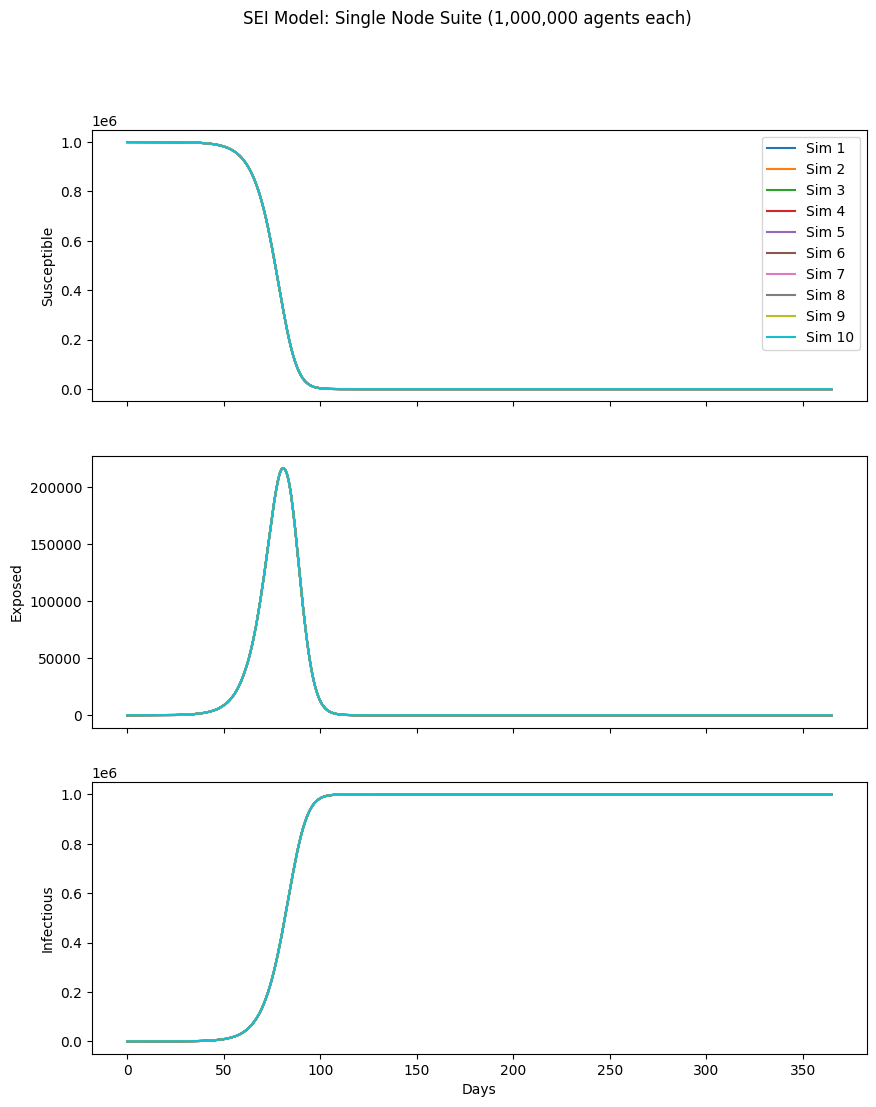

In [5]:
from laser.core.utils import grid
from laser.core.random import seed as set_seed
from laser.generic import Model
from laser.core import PropertySet
from laser.core.distributions import normal

initial_infectious = 10
seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
nticks = 365

scenario = grid(M=1, N=1, node_size_degs=0.1, population_fn=lambda x, y: 1_000_000)
scenario["S"] = scenario.population - initial_infectious
scenario["E"] = 0
scenario["I"] = initial_infectious

results_sei = []
for i, seed in enumerate(seeds):
    set_seed(seed)
    model = Model(scenario, params=PropertySet({"beta": 0.3, "seed": seed, "nticks": nticks}), skip_capacity=True)
    exposure_duration = normal(loc=5, scale=1.5)
    model.components = [
        Susceptible(model),
        Infectious(model),  # Infectious goes _before_ Exposed so the previous I count is propagated before the Exposed step updates it.
        ExposedSEI(model, expdurdist=exposure_duration, expdurmin=1), # ExposedSEI needs the exposure duration distribution for initializing exposed agents.
        Transmission(model, expdurdist=exposure_duration, expdurmin=1), # Transmission needs the exposure duration distribution to set the exposure timers on newly infected agents.
    ]

    model.run(f"Scenario {i+1:2}/{len(seeds)} (seed={seed:2})")
    results_sei.append((model.nodes.S, model.nodes.E, model.nodes.I))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
for i, (S, E, I) in enumerate(results_sei):
    ax[0].plot(S.sum(axis=1), label=f"Sim {i+1}")
    ax[1].plot(E.sum(axis=1), label=f"Sim {i+1}")
    ax[2].plot(I.sum(axis=1), label=f"Sim {i+1}")
ax[0].set_ylabel("Susceptible")
ax[1].set_ylabel("Exposed")
ax[2].set_ylabel("Infectious")
ax[2].set_xlabel("Days")
ax[0].legend()
plt.suptitle("SEI Model: Single Node Suite (1,000,000 agents each)")
plt.show()


## SI model for comparison

Let's run 10 SI models with same R0 for comparison.

Scenario 10/10 (seed=89): 100%|██████████| 365/365 [00:00<00:00, 2780.59it/s]


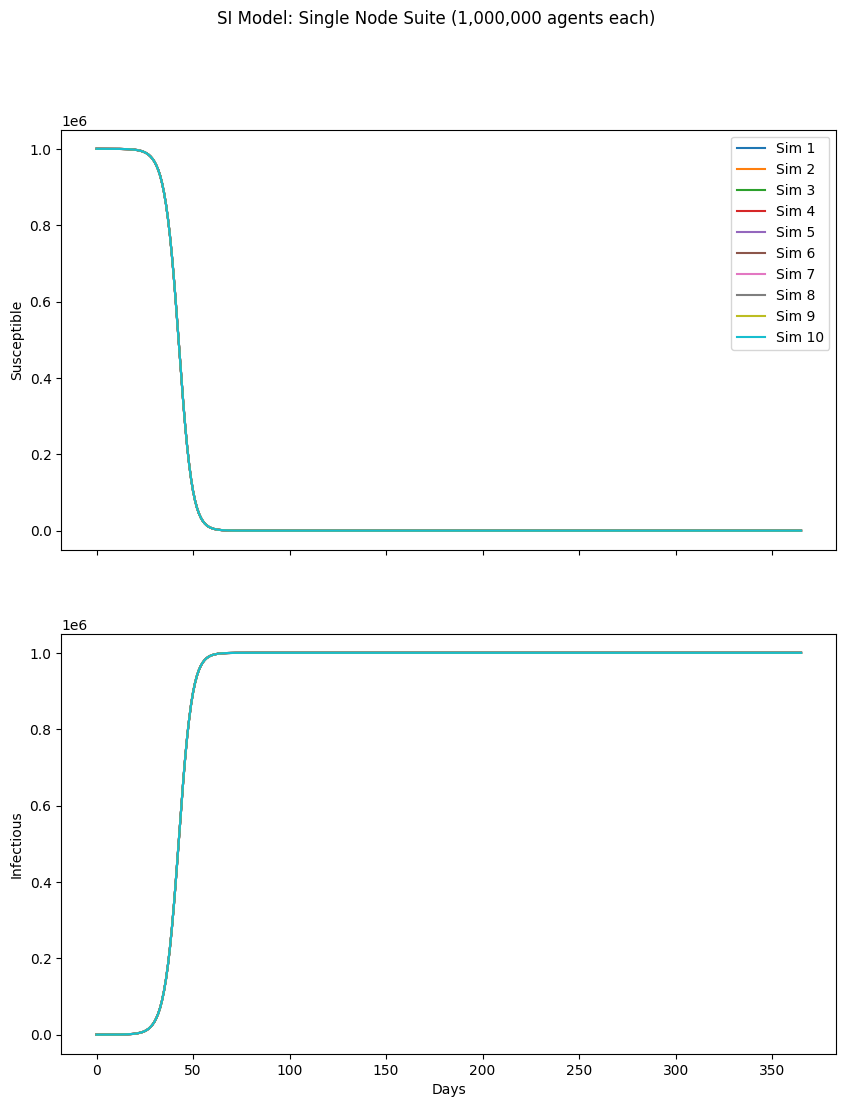

In [6]:
from laser.generic import SI

# Let's run 10 SI models with same R0 for comparison.
results_si = []
for i, seed in enumerate(seeds):
    set_seed(seed)
    model = Model(scenario, params=PropertySet({"beta": 0.3, "seed": seed, "nticks": nticks}), skip_capacity=True)
    exposure_duration = normal(loc=5, scale=1.5)
    model.components = [
        SI.Susceptible(model),
        SI.Infectious(model),
        SI.Transmission(model),
    ]

    model.run(f"Scenario {i+1:2}/{len(seeds)} (seed={seed:2})")
    results_si.append((model.nodes.S, model.nodes.I))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
for i, (S, I) in enumerate(results_si):
    ax[0].plot(S.sum(axis=1), label=f"Sim {i+1}")
    ax[1].plot(I.sum(axis=1), label=f"Sim {i+1}")
ax[0].set_ylabel("Susceptible")
ax[1].set_ylabel("Infectious")
ax[1].set_xlabel("Days")
ax[0].legend()
plt.suptitle("SI Model: Single Node Suite (1,000,000 agents each)")
plt.show()


Let's plot a comparison between the two.

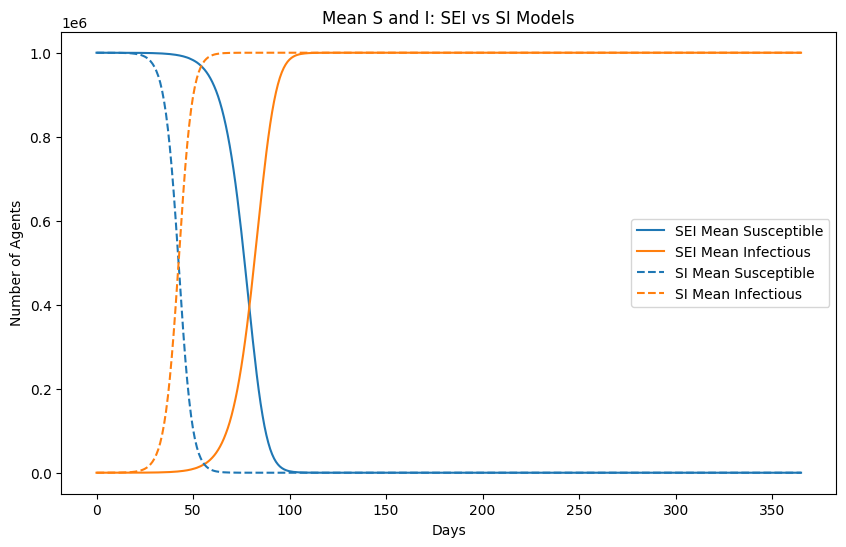

In [7]:
import numpy as np

import matplotlib.pyplot as plt

# Compute mean S and I for SEI model
S_sei = np.array([S for S, E, I in results_sei])  # shape: (n_sim, n_time, 1)
I_sei = np.array([I for S, E, I in results_sei])
mean_S_sei = S_sei.mean(axis=0).squeeze()
mean_I_sei = I_sei.mean(axis=0).squeeze()

# Compute mean S and I for SI model
S_si = np.array([S for S, I in results_si])
I_si = np.array([I for S, I in results_si])
mean_S_si = S_si.mean(axis=0).squeeze()
mean_I_si = I_si.mean(axis=0).squeeze()

plt.figure(figsize=(10, 6))
plt.plot(mean_S_sei, label="SEI Mean Susceptible", color="tab:blue")
plt.plot(mean_I_sei, label="SEI Mean Infectious", color="tab:orange")
plt.plot(mean_S_si, label="SI Mean Susceptible", color="tab:blue", linestyle="--")
plt.plot(mean_I_si, label="SI Mean Infectious", color="tab:orange", linestyle="--")
plt.xlabel("Days")
plt.ylabel("Number of Agents")
plt.title("Mean S and I: SEI vs SI Models")
plt.legend()
plt.show()

### Results

As expected, the SEI model takes longer to get started due to the delay imposed by the incubation period (exposed state).

## An SEIS model implementation

We can use the common Susceptible component. ✅

We can use the Exposed component from the SEIR model which expects both an incubation/exposure timer and an infectious duration timer. ✅

⇒ _We will need a new Infectious component which transitions agents from infectious to susceptible when the infectious timer expires._ ⇐

We can use the Transmission component from the SEIR/SEIRS models which knows to transition susceptible agents into exposed agents upon infection. ✅


We will base the new Infectious component on the SEIR.Infectious component but will transition from I to S rather than from I to R.

In [8]:
from laser.generic import SEIR

class InfectiousSEIS(SEIR.Infectious):

    def step(self, tick: int) -> None:
        # Propagate the number of infectious individuals in each patch
        # state(t+1) = state(t) + ∆state(t), initialize state(t+1) with state(t)
        self.model.nodes.I[tick + 1] = self.model.nodes.I[tick]

        newly_recovered_by_node = np.zeros((nb.get_num_threads(), self.model.nodes.count), dtype=np.int32)
        nb_timer_update(
            self.model.people.state,
            State.INFECTIOUS.value,
            self.model.people.itimer,
            State.SUSCEPTIBLE.value,  # Transition to SUSCEPTIBLE
            newly_recovered_by_node,
            self.model.people.nodeid,
        )
        newly_recovered_by_node = newly_recovered_by_node.sum(axis=0).astype(self.model.nodes.S.dtype)  # Sum over threads

        # state(t+1) = state(t) + ∆state(t)
        self.model.nodes.I[tick + 1] -= newly_recovered_by_node
        self.model.nodes.S[tick + 1] += newly_recovered_by_node
        # Record today's ∆
        self.model.nodes.newly_recovered[tick] = newly_recovered_by_node

        return

### SEIS model

Let's compose and run this model.


Scenario 10/10 (seed=89): 100%|██████████| 365/365 [00:00<00:00, 435.73it/s]


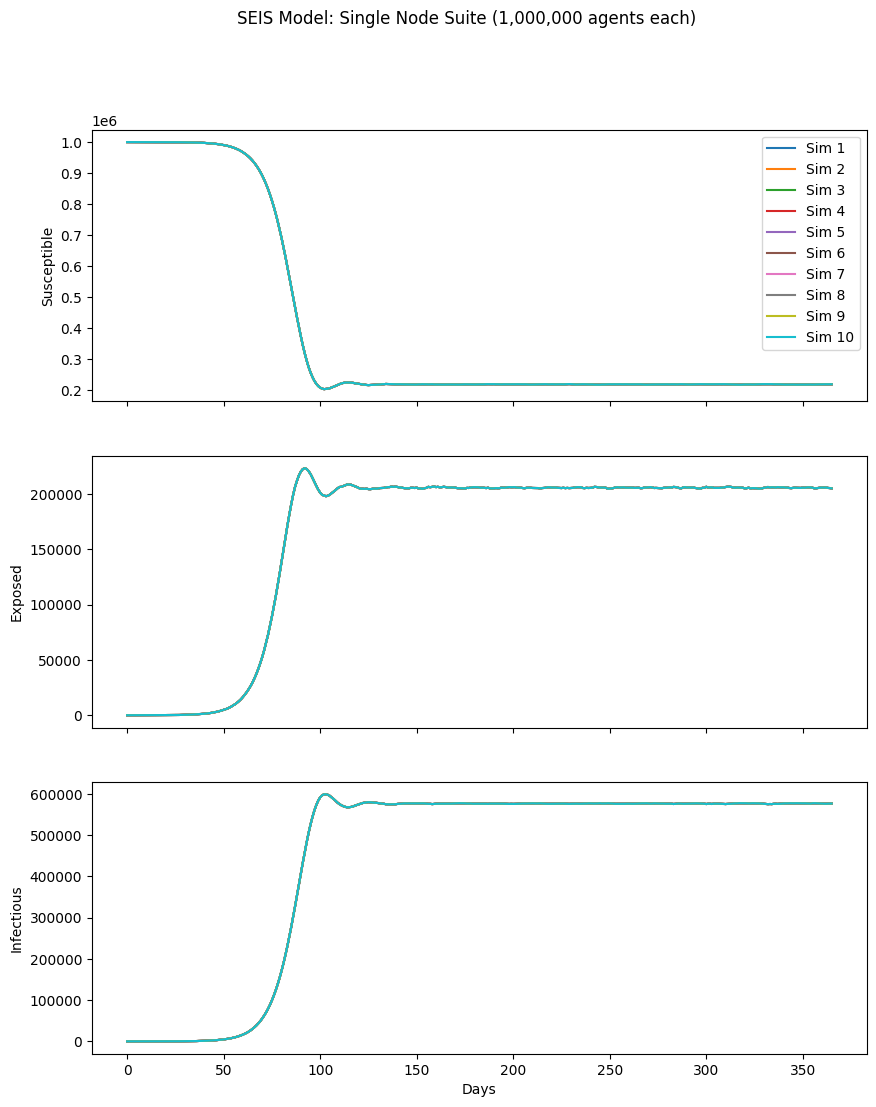

In [9]:
initial_infectious = 10
seeds = [1, 2, 3, 5, 8, 13, 21, 34, 55, 89]
nticks = 365

scenario = grid(M=1, N=1, node_size_degs=0.1, population_fn=lambda x, y: 1_000_000)
scenario["S"] = scenario.population - initial_infectious
scenario["E"] = 0
scenario["I"] = initial_infectious

results_seis = []
for i, seed in enumerate(seeds):
    set_seed(seed)
    model = Model(scenario, params=PropertySet({"beta": 0.3, "seed": seed, "nticks": nticks}), skip_capacity=True)
    exposure_duration = normal(loc=5, scale=1.5)
    infectious_duration = normal(loc=14, scale=2.0)
    model.components = [
        Susceptible(model),
        InfectiousSEIS(model, infdurdist=infectious_duration, infdurmin=1),  # Infectious goes _before_ Exposed so the previous I count is propagated before the Exposed step updates it.
        SEIR.Exposed(model, expdurdist=exposure_duration, expdurmin=1, infdurdist=infectious_duration, infdurmin=1), # ExposedSEI needs the exposure duration distribution for initializing exposed agents.
        SEIR.Transmission(model, expdurdist=exposure_duration, expdurmin=1), # Transmission needs the exposure duration distribution to set the exposure timers on newly infected agents.
    ]

    model.run(f"Scenario {i+1:2}/{len(seeds)} (seed={seed:2})")
    results_seis.append((model.nodes.S, model.nodes.E, model.nodes.I))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
for i, (S, E, I) in enumerate(results_seis):
    ax[0].plot(S.sum(axis=1), label=f"Sim {i+1}")
    ax[1].plot(E.sum(axis=1), label=f"Sim {i+1}")
    ax[2].plot(I.sum(axis=1), label=f"Sim {i+1}")
ax[0].set_ylabel("Susceptible")
ax[1].set_ylabel("Exposed")
ax[2].set_ylabel("Infectious")
ax[2].set_xlabel("Days")
ax[0].legend()
plt.suptitle("SEIS Model: Single Node Suite (1,000,000 agents each)")
plt.show()

## Comparison with SEI model

We already have the results for the SEI model, let's compare.

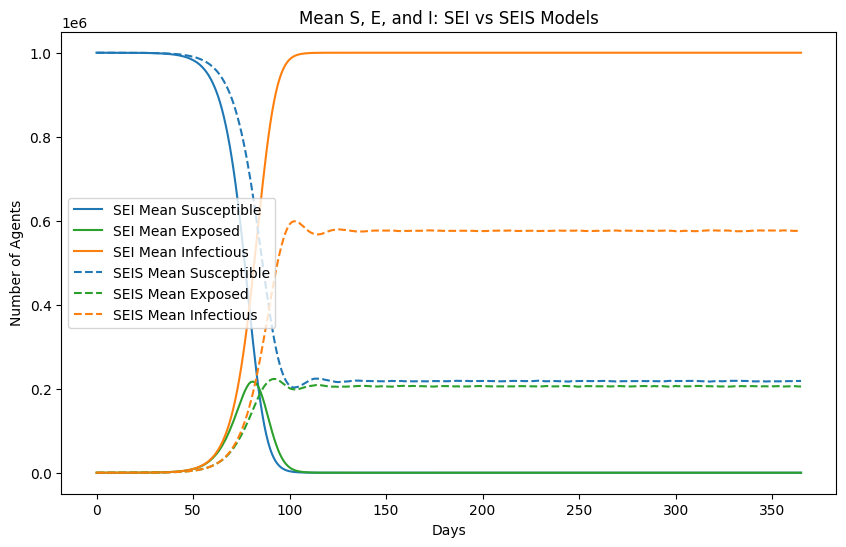

In [10]:
# # Compute mean S, E, and I for SEI model
# S_sei = np.array([S for S, E, I in results_sei])  # shape: (n_sim, n_time, 1)
E_sei = np.array([E for S, E, I in results_sei])
# I_sei = np.array([I for S, E, I in results_sei])
# mean_S_sei = S_sei.mean(axis=0).squeeze()
mean_E_sei = E_sei.mean(axis=0).squeeze()
# mean_I_sei = I_sei.mean(axis=0).squeeze()

# Compute mean S, E, and I for SEIS model
S_seis = np.array([S for S, E, I in results_seis])
E_seis = np.array([E for S, E, I in results_seis])
I_seis = np.array([I for S, E, I in results_seis])
mean_S_seis = S_seis.mean(axis=0).squeeze()
mean_E_seis = E_seis.mean(axis=0).squeeze()
mean_I_seis = I_seis.mean(axis=0).squeeze()

plt.figure(figsize=(10, 6))
plt.plot(mean_S_sei, label="SEI Mean Susceptible", color="tab:blue")
plt.plot(mean_E_sei, label="SEI Mean Exposed", color="tab:green")
plt.plot(mean_I_sei, label="SEI Mean Infectious", color="tab:orange")
plt.plot(mean_S_seis, label="SEIS Mean Susceptible", color="tab:blue", linestyle="--")
plt.plot(mean_E_seis, label="SEIS Mean Exposed", color="tab:green", linestyle="--")
plt.plot(mean_I_seis, label="SEIS Mean Infectious", color="tab:orange", linestyle="--")
plt.xlabel("Days")
plt.ylabel("Number of Agents")
plt.title("Mean S, E, and I: SEI vs SEIS Models")
plt.legend()
plt.show()

### Results

As we might expect, the SEIS model proceeds a little more slowly because infectious agents are recovering and returning to the susceptible state which lowers the force of infection.

In addition, while the SEI model eventually infects everyone, the SEIS model reaches an equilibrium state between ongoing incidence and return to the susceptible state.